# Data Challenge 2022 : Real estate price prediction
We've chosen to tackle tha Reak estate price detection data challenge provided by by Institut Louis Bachelier. Before getting started we're going to load all the necessary libraries that we're going to use during this challenge.

In [2]:
#!python -m pip install -r requirements.txt

In [21]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy as sp
from scipy.stats import skew
from pycaret.regression import compare_models, setup
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows=50
pd.options.display.max_columns=28

## 1. Data Exploration :
In this section, we're going to load our data, explore and analyse it and try to extract meaningful insights before applying nay preprocessing steps to it.

In [22]:
# Loading the Data
filepath='data/'
# Raw Loaded data
X_train_raw=pd.read_csv(filepath +'X_train_J01Z4CN.csv') 
Y_train_raw=pd.read_csv(filepath + 'y_train_OXxrJt1.csv')

Y_test_raw=pd.read_csv(filepath + 'y_random_MhJDhKK.csv')
X_test_raw=pd.read_csv(filepath + 'X_test_BEhvxAN.csv')

# Droping ids for training
X_train_0=X_train_raw.drop(columns="id_annonce")
Y_train_0=Y_train_raw.drop(columns="id_annonce")

X_test_0=X_test_raw.drop(columns="id_annonce")

# Saving Test ids for prediction
X_test_ids=X_test_raw["id_annonce"]
X_test_ids.to_pickle("data/X_test_ids.pkl")



In [23]:
print(f" Number of training rows : {X_train_0.index.max()}")
print(f" Numer of testing rows : {len(X_test_0.index)}")

 Number of training rows : 37367
 Numer of testing rows : 9339


In [24]:
X_train_0.head()

,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,energy_performance_category,ghg_value,ghg_category,exposition,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,D,52.0,E,NaN,5.0,4.0,NaN,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,NaN,NaN,NaN,Sud,2.0,1.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,D,44.0,E,NaN,4.0,3.0,NaN,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,1.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_train_0.describe().T.style.background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['mean'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
approximate_latitude,37368.000000,46.546155,2.356581,41.374436,43.921547,46.939440,48.841511,51.075892
approximate_longitude,37368.000000,2.619087,2.597060,-4.733545,1.096014,2.380793,4.624248,9.503198
postal_code,37368.000000,53598.371655,28807.220527,1000.000000,30150.000000,59000.000000,78210.000000,95880.000000
size,36856.000000,1088.831615,5555.320867,1.000000,74.000000,115.000000,235.250000,411311.000000
floor,9743.000000,3.479524,6.725577,1.000000,1.000000,2.000000,4.000000,55.000000
land_size,15581.000000,3995.665362,54415.954149,1.000000,362.000000,795.000000,1841.000000,6203700.000000
energy_performance_value,19068.000000,205.385148,790.501769,0.000000,125.000000,180.000000,239.000000,100000.000000
ghg_value,18530.000000,31.845548,310.576209,0.000000,8.000000,16.000000,36.000000,17024.000000
nb_rooms,35802.000000,4.245405,2.987782,0.000000,3.000000,4.000000,5.000000,130.000000
nb_bedrooms,34635.000000,2.864877,2.156517,0.000000,2.000000,3.000000,4.000000,118.000000


In [26]:
X_test_0.describe().T.style.background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['mean'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
approximate_latitude,9339.000000,46.535067,2.360984,41.375431,43.861462,46.970358,48.838557,51.043964
approximate_longitude,9339.000000,2.669378,2.591835,-4.772225,1.199869,2.384187,4.696350,9.505589
postal_code,9339.000000,53692.717529,28814.927701,1000.000000,30325.000000,59000.000000,78200.000000,95880.000000
size,9203.000000,1128.937955,5884.783291,1.000000,75.000000,115.000000,230.500000,279853.000000
floor,2485.000000,3.448290,6.520826,1.000000,1.000000,2.000000,4.000000,55.000000
land_size,3852.000000,3789.233385,24952.936437,1.000000,362.000000,780.500000,1756.500000,1070469.000000
energy_performance_value,4828.000000,229.512635,1588.818851,1.000000,126.000000,180.000000,236.000000,100000.000000
ghg_value,4679.000000,35.570421,385.411241,1.000000,8.000000,15.000000,36.000000,15126.000000
nb_rooms,8985.000000,4.258987,3.248541,0.000000,3.000000,4.000000,5.000000,125.000000
nb_bedrooms,8705.000000,2.887536,2.469085,0.000000,2.000000,3.000000,4.000000,90.000000


In [107]:
X_train_0.select_dtypes(object)

,property_type,city,energy_performance_category,ghg_category,exposition
0,appartement,villeneuve-loubet,NaN,NaN,NaN
1,appartement,venissieux,D,E,NaN
2,maison,moutiers,NaN,NaN,Sud
3,maison,cordemais,D,E,NaN
4,appartement,lyon-7eme,NaN,NaN,NaN
...,...,...,...,...,...
37363,appartement,bayonne,E,F,NaN
37364,appartement,paris-20eme,D,E,Sud
37365,appartement,biscarrosse,NaN,NaN,NaN
37366,duplex,magny-le-hongre,NaN,NaN,NaN


In [108]:
X_train_0.select_dtypes(np.number)

,approximate_latitude,approximate_longitude,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,43.643880,7.117183,6270,63.0,NaN,NaN,NaN,NaN,3.0,2.0,NaN,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,45.695757,4.895610,69200,90.0,3.0,NaN,223.0,52.0,5.0,4.0,NaN,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.966791,-1.220451,35130,61.0,NaN,370.0,NaN,NaN,2.0,1.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.289292,-1.878805,44360,142.0,NaN,764.0,217.0,44.0,4.0,3.0,NaN,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,45.718992,4.844234,69007,88.0,3.0,NaN,NaN,NaN,4.0,3.0,1.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37363,43.480292,-1.484324,64100,2995.0,NaN,NaN,255.0,59.0,1.0,NaN,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37364,48.861391,2.401158,75020,36.0,4.0,NaN,229.0,53.0,2.0,1.0,NaN,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37365,44.397837,-1.164312,40600,99.0,2.0,NaN,NaN,NaN,4.0,3.0,NaN,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37366,48.864204,2.808693,77700,9281.0,NaN,NaN,NaN,NaN,5.0,4.0,NaN,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### a. Features ditribution

In [27]:
categorical_features = ["property_type","city","energy_performance_category","ghg_category","exposition", "postal_code"]
numerical_features = ["approximate_latitude", "approximate_longitude","size", "floor","land_size","energy_performance_value","ghg_value","nb_rooms","nb_bedrooms","nb_bathrooms","nb_parking_places","nb_boxes","nb_photos","nb_terraces"]
boolean_features = ["has_a_cellar","has_a_garage", "has_air_conditioning", "last_floor", "upper_floors"]

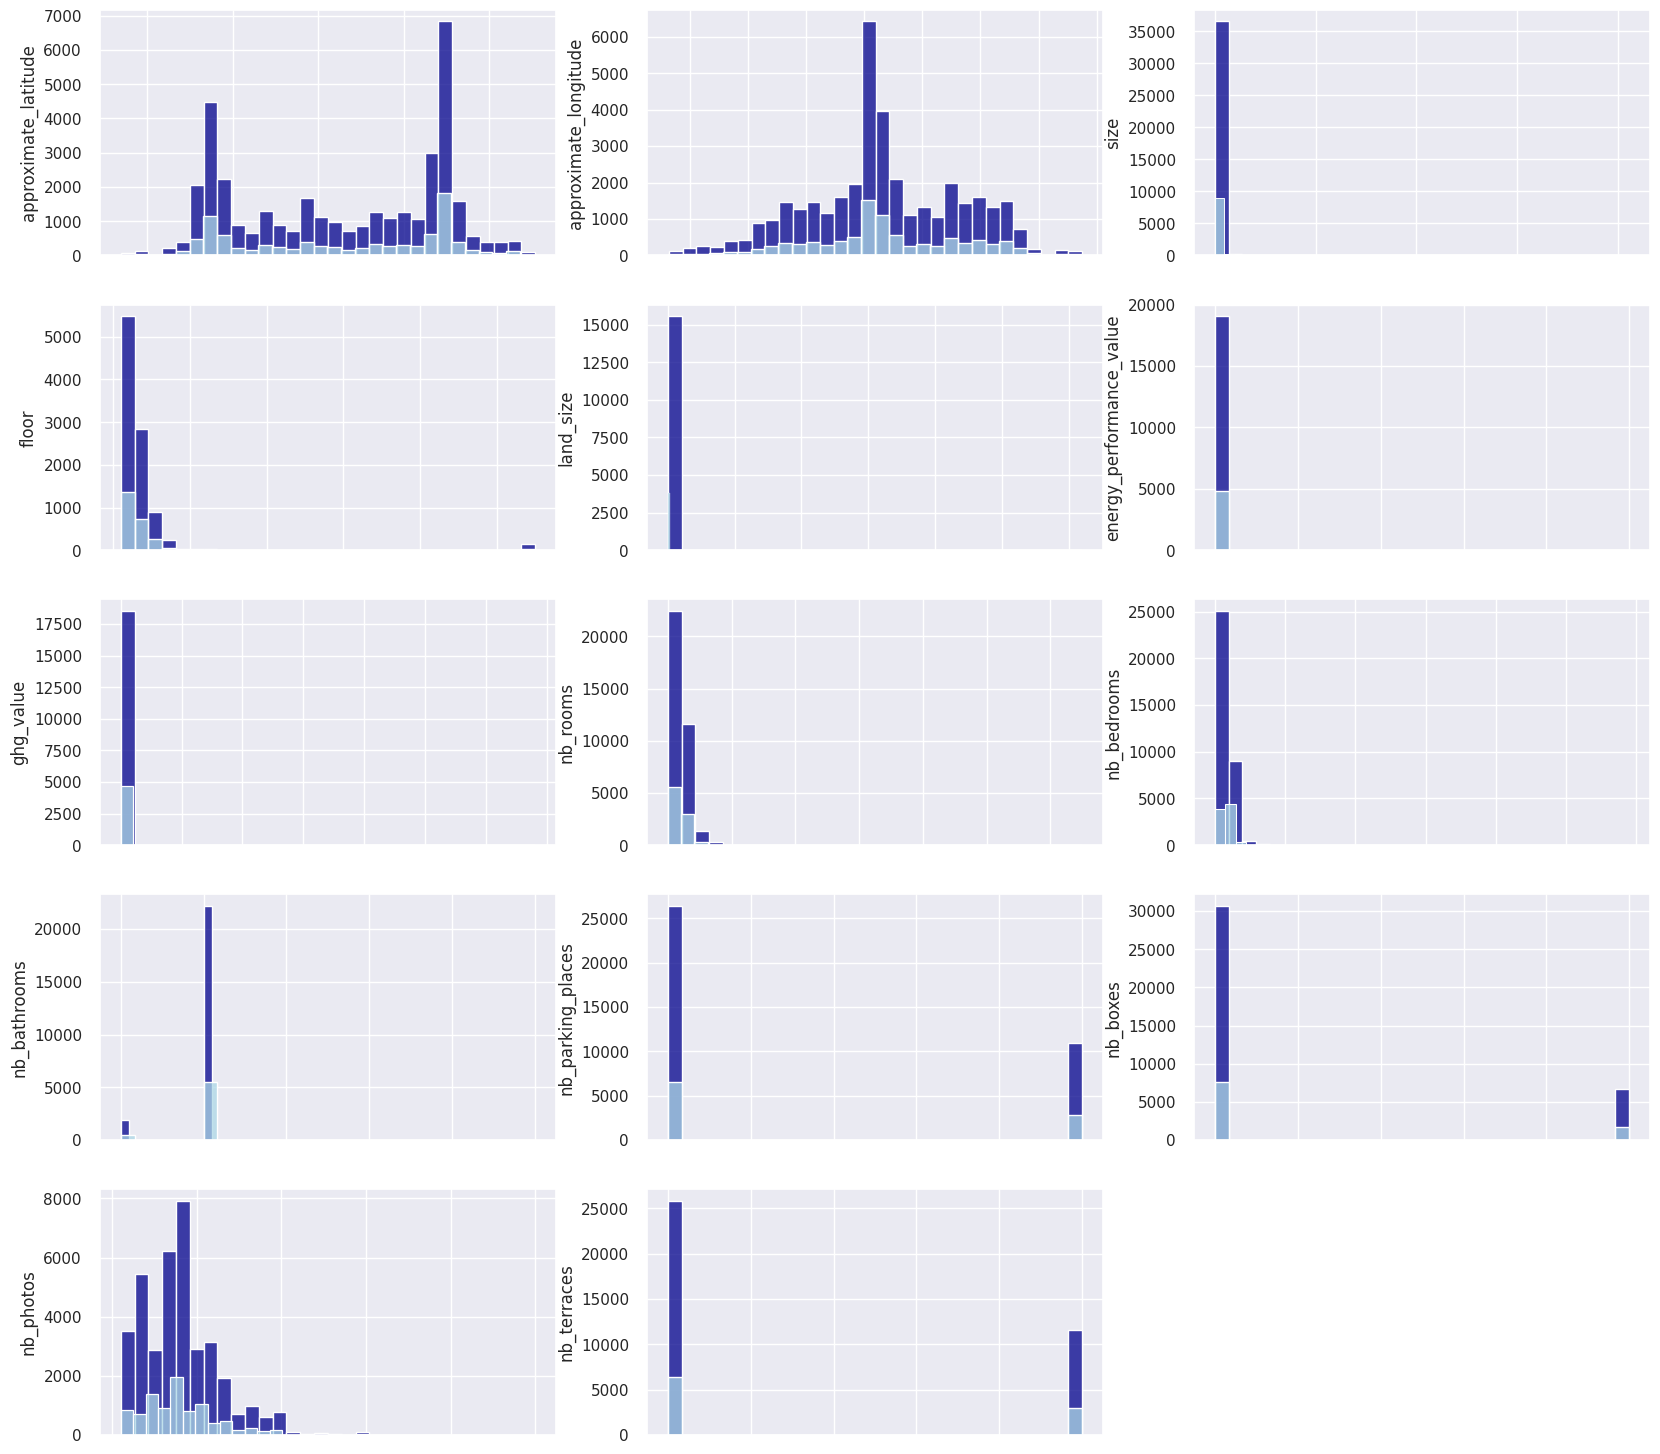

In [28]:
sb.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(numerical_features):
    plt.subplot(8,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sb.histplot(data=X_train_0, x=X_train_0[feature], bins=30,  color='darkblue') 
    g2 = sb.histplot(data=X_test_0, x=X_test_0[feature], bins=30, color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False)

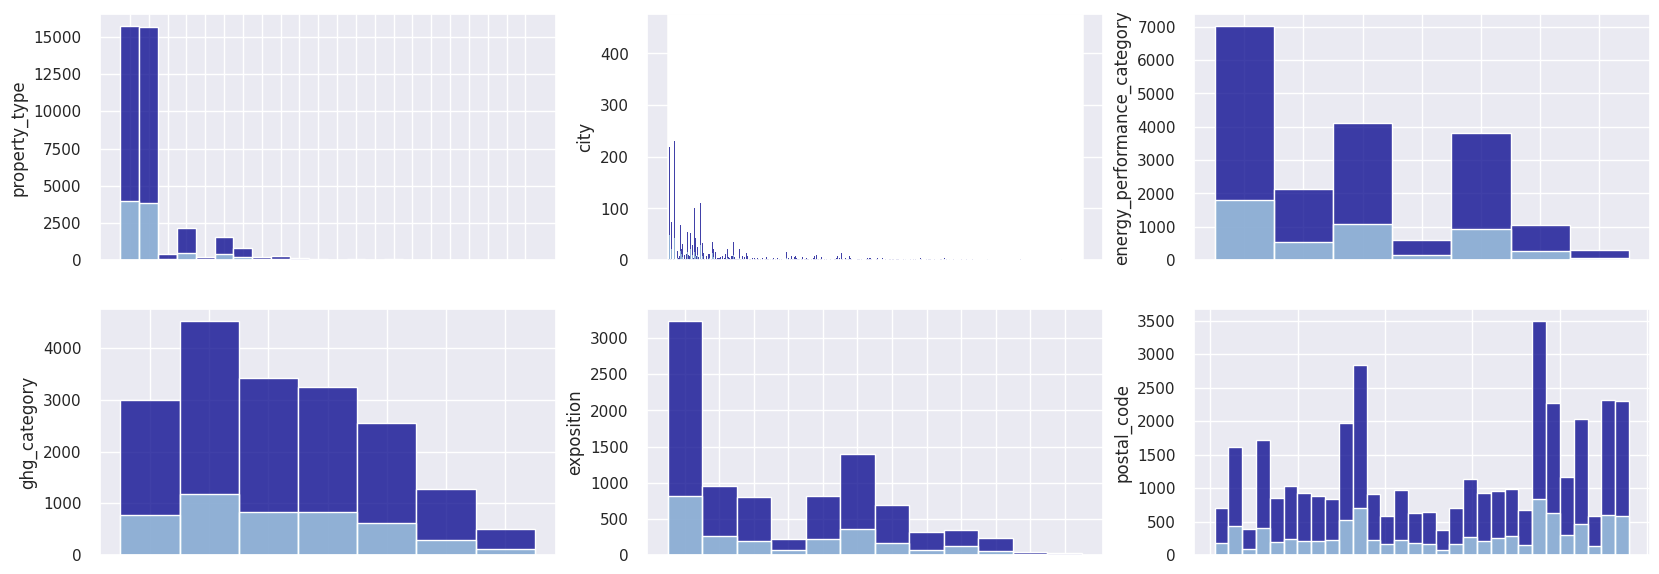

In [29]:
sb.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(categorical_features):
    plt.subplot(8,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sb.histplot(data=X_train_0, x=X_train_0[feature], bins=30,  color='darkblue') 
    g2 = sb.histplot(data=X_test_0, x=X_test_0[feature], bins=30, color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False)

### a. Features cardinality

In [112]:
# Train set features cardinality
train_cardinality = (pd.Series({feature: len(X_train_0[feature].unique()) for feature in X_train_0[categorical_features]})
                     .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
sb.set(rc={"figure.figsize":(5, 6)})

# Test set features cardinality
test_cardinality = (pd.Series({feature: len(X_test_0[feature].unique()) for feature in X_test_0[categorical_features]})
                     .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))
sb.set(rc={"figure.figsize":(5, 6)})

In [113]:
(pd.merge(train_cardinality,test_cardinality, on='Feature', how='left')
 .sort_values(by=['Cardinality_x', 'Cardinality_y'], ascending=[False,False])
 .rename(columns={'Cardinality_x':'Train Cardinality','Cardinality_y':'Test Cardinality'}))

,Feature,Train Cardinality,Test Cardinality
1,city,8643,3833
5,postal_code,4726,2964
0,property_type,22,20
4,exposition,13,13
2,energy_performance_category,8,8
3,ghg_category,8,8


In [30]:
(pd.Series(X_train_0.isna().sum()/len(X_train_0.index)*100).reset_index().
    rename(columns={'index':'Feature',0:'Missing_Values'}).
    sort_values(by=['Missing_Values'], ascending=[False]))



,Feature,Missing_Values
12,exposition,75.663669
6,floor,73.926889
7,land_size,58.303896
10,ghg_value,50.412117
11,ghg_category,50.412117
9,energy_performance_category,48.972383
8,energy_performance_value,48.972383
15,nb_bathrooms,35.519696
14,nb_bedrooms,7.313744
13,nb_rooms,4.190751


## 1. Cleaning the data
### a. Feautures cleaning :
We have a set of redundant Features, for example :

- 'energy_performance_category' which is derived from 'energy_performance_value'
- 'ghg_category' which is derived from 'ghg_value'
- 'postal_code', 'city', 'approximate_latitude', and 'approximate_longtitude' 

we also have an issue with high cardinality features, especially 'postal_code' and 'city'

In [33]:
data = pd.concat([X_train_0, X_test_0], axis=0).reset_index(drop=True)
data_0=data.drop(columns=["energy_performance_category", "ghg_category"])

### b. Dealing with NaN Values :

Missing values :

```
size                             512 # Numerical
floor                          27625 # Numerical
land_size                      21787 # Numerical
energy_performance_value       18300 # Numerical
energy_performance_category    18300 # Categorical
ghg_value                      18838 # Numerical
ghg_category                   18838 # Categorical
exposition                     28274 # Categorical
nb_rooms                        1566 # Numerical
nb_bedrooms                     2733 # Numerical
nb_bathrooms                   13273 # Numerical
```

- For houses we'll set the the floor value at 0
- For appartements we'll set the landsize value at 0

Based on the missing values heatmap we'll drop : 
- Energy__performance_category (Derived Data from Energy_performance value)
- GHG_category (Derived Data from ghg_value)
- Exposition (75.66% missing Data)


In [34]:
# Dropping the columns
data_1=data_0.drop(columns=["exposition"])

In [35]:
#KNN imputation / Try and expirement different imputations
def knn_impute(df0, column):
    """ 
    """
    # Creating a copy of the input dataframe
    df = df0.copy()

    # numeric_df : subset of df composed only of numerical data type colums
    numeric_df = df.select_dtypes(np.number)

    # full columns : columns that have no missing data
    full_columns=numeric_df.loc[:,numeric_df.isna().sum()==0].columns

    # knn_x_train : training data for the missing values
    knn_x_train = numeric_df.loc[numeric_df[column].isna()==False, full_columns]

    # knn_y_train: target data for the missing valies 
    knn_y_train= numeric_df.loc[numeric_df[column].isna()==False, column]

    # knn_x_test : the data with missing values for the target column
    knn_x_test = numeric_df.loc[numeric_df[column].isna()==True, full_columns]

    # Creating the KNeighbors Regress
    knn=KNeighborsRegressor()

    # Fitting the model
    knn.fit(knn_x_train, knn_y_train)

    y_pred=knn.predict(knn_x_test)

    df.loc[df[column].isna()==True, column]=y_pred

    return df

# Applies knn imputation over a list of columns
def knn_impute_all(df, list_columns):
    """
    """
    for column in list_columns:
        df=knn_impute(df,column)
    return df

In [36]:
list_columns = ["size", "land_size","energy_performance_value","ghg_value", "nb_rooms","nb_bathrooms", "nb_bedrooms"]
#Applies knn imputation on list_columns
data_2 = knn_impute_all(data_1, list_columns=list_columns)
data_2.isna().sum()


property_type                   0
approximate_latitude            0
approximate_longitude           0
city                            0
postal_code                     0
size                            0
floor                       34479
land_size                       0
energy_performance_value        0
ghg_value                       0
nb_rooms                        0
nb_bedrooms                     0
nb_bathrooms                    0
nb_parking_places               0
nb_boxes                        0
nb_photos                       0
has_a_balcony                   0
nb_terraces                     0
has_a_cellar                    0
has_a_garage                    0
has_air_conditioning            0
last_floor                      0
upper_floors                    0
dtype: int64

In [38]:
#Set floor value to 0 for all property types that are not appartements
data_2.loc[(data_2['property_type']!="appartement"), 'floor'] = 0
data_2.isna().sum()

property_type                  0
approximate_latitude           0
approximate_longitude          0
city                           0
postal_code                    0
size                           0
floor                       7684
land_size                      0
energy_performance_value       0
ghg_value                      0
nb_rooms                       0
nb_bedrooms                    0
nb_bathrooms                   0
nb_parking_places              0
nb_boxes                       0
nb_photos                      0
has_a_balcony                  0
nb_terraces                    0
has_a_cellar                   0
has_a_garage                   0
has_air_conditioning           0
last_floor                     0
upper_floors                   0
dtype: int64

In [ ]:
#Applies KNN imputations to the appartements with no floor value
data_3=knn_impute(data_2, "floor")

# Mode imputation
# data_2['floor'] = data_2['floor'].fillna(data_2['floor'].mode()[0])
# data_3=data_2.copy()

## 2. Feature Engineering 


## 3. Feature Transformations 


In [8]:
for column in data_3.select_dtypes(np.number).columns :
    print(f"{column} : {skew(data_3[column])}")

approximate_latitude : -0.17668422243900067
approximate_longitude : -0.055180451912759186
postal_code : -0.18004164772525946
size : 35.62458442281074
floor : 10.663940258984347
land_size : 148.50811096838808
energy_performance_value : 84.91844298091794
ghg_value : 35.72285554604757
nb_rooms : 8.68528762894486
nb_bedrooms : 10.422141304674824
nb_bathrooms : -3.3775187988735866
nb_parking_places : 0.9007961591725067
nb_boxes : 1.6653362986059093
nb_photos : 1.0264598706000085
has_a_balcony : 1.9767280451382223
nb_terraces : 0.8194890109971716
has_a_cellar : 1.4997323999430818
has_a_garage : 3.9532622633037113
has_air_conditioning : 4.665611329764892
last_floor : 16.15193981940325
upper_floors : 65.13901399819561


## 4. Encoding
Issue 1 : Hot encoding city column : explostion in dimensionality (for now I dropped it )
possible solution : Frequency encoding / Target encoding

In [10]:
data_4 = pd.get_dummies(data_3)
data_4.head()

,approximate_latitude,approximate_longitude,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,...,property_type_gîte,property_type_hôtel,property_type_hôtel particulier,property_type_loft,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
0,43.643880,7.117183,6270,63.0,0.8,244.6,158.0,7.2,3.0,2.0,1.0,0.0,0.0,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,45.695757,4.895610,69200,90.0,3.0,273.0,223.0,52.0,5.0,4.0,0.8,0.0,0.0,8.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,47.966791,-1.220451,35130,61.0,0.0,370.0,138.6,25.2,2.0,1.0,1.0,0.0,0.0,4.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,47.289292,-1.878805,44360,142.0,0.0,764.0,217.0,44.0,4.0,3.0,1.0,0.0,1.0,8.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,45.718992,4.844234,69007,88.0,3.0,38.6,89.8,12.2,4.0,3.0,1.0,0.0,1.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 5. Scaling


In [11]:
scaler = StandardScaler()
scaler.fit(data_4)
data_5=pd.DataFrame(scaler.transform(data_4), index=data_4.index, columns=data_4.columns)

In [141]:
data_5.head()

,approximate_latitude,approximate_longitude,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,...,property_type_gîte,property_type_hôtel,property_type_hôtel particulier,property_type_loft,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
0,-1.230185,1.728803,-0.185084,2.909012,-0.089150,-0.207595,-0.115127,-0.413984,-0.377486,-0.536235,-0.646351,-0.468614,-0.856026,-0.417646,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
1,-0.359793,0.873048,-0.180253,0.477197,-0.074136,-0.001916,0.054427,0.248147,0.533524,0.292442,-0.646351,-0.468614,0.006854,-0.417646,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
2,0.603565,-1.482872,-0.185441,-0.315786,-0.080624,-0.106461,-0.058360,-0.745049,-0.832991,0.292442,-0.646351,-0.468614,-0.856026,-0.417646,...,-0.009255,-0.004627,-0.012243,-0.039293,1.179588,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
3,0.316174,-1.736472,-0.170950,-0.315786,-0.068984,-0.009227,0.024550,-0.082918,0.078019,0.292442,-0.646351,2.133951,0.006854,-0.417646,...,-0.009255,-0.004627,-0.012243,-0.039293,1.179588,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
4,-0.349936,0.853258,-0.180611,0.477197,-0.038005,-0.015563,-0.030723,-0.082918,0.078019,0.292442,-0.646351,2.133951,-0.640306,2.394374,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156


## 6. Target Transformation


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

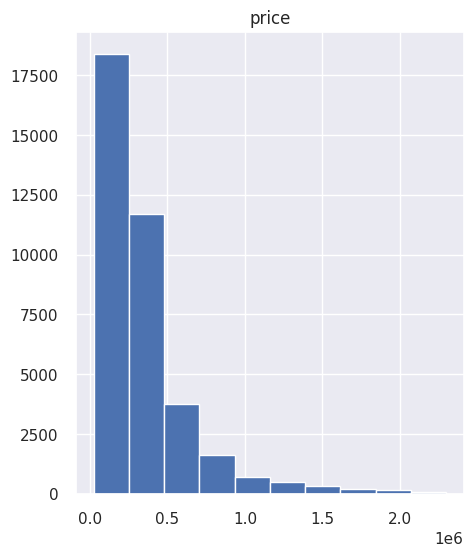

In [142]:
Y_train_0.hist()

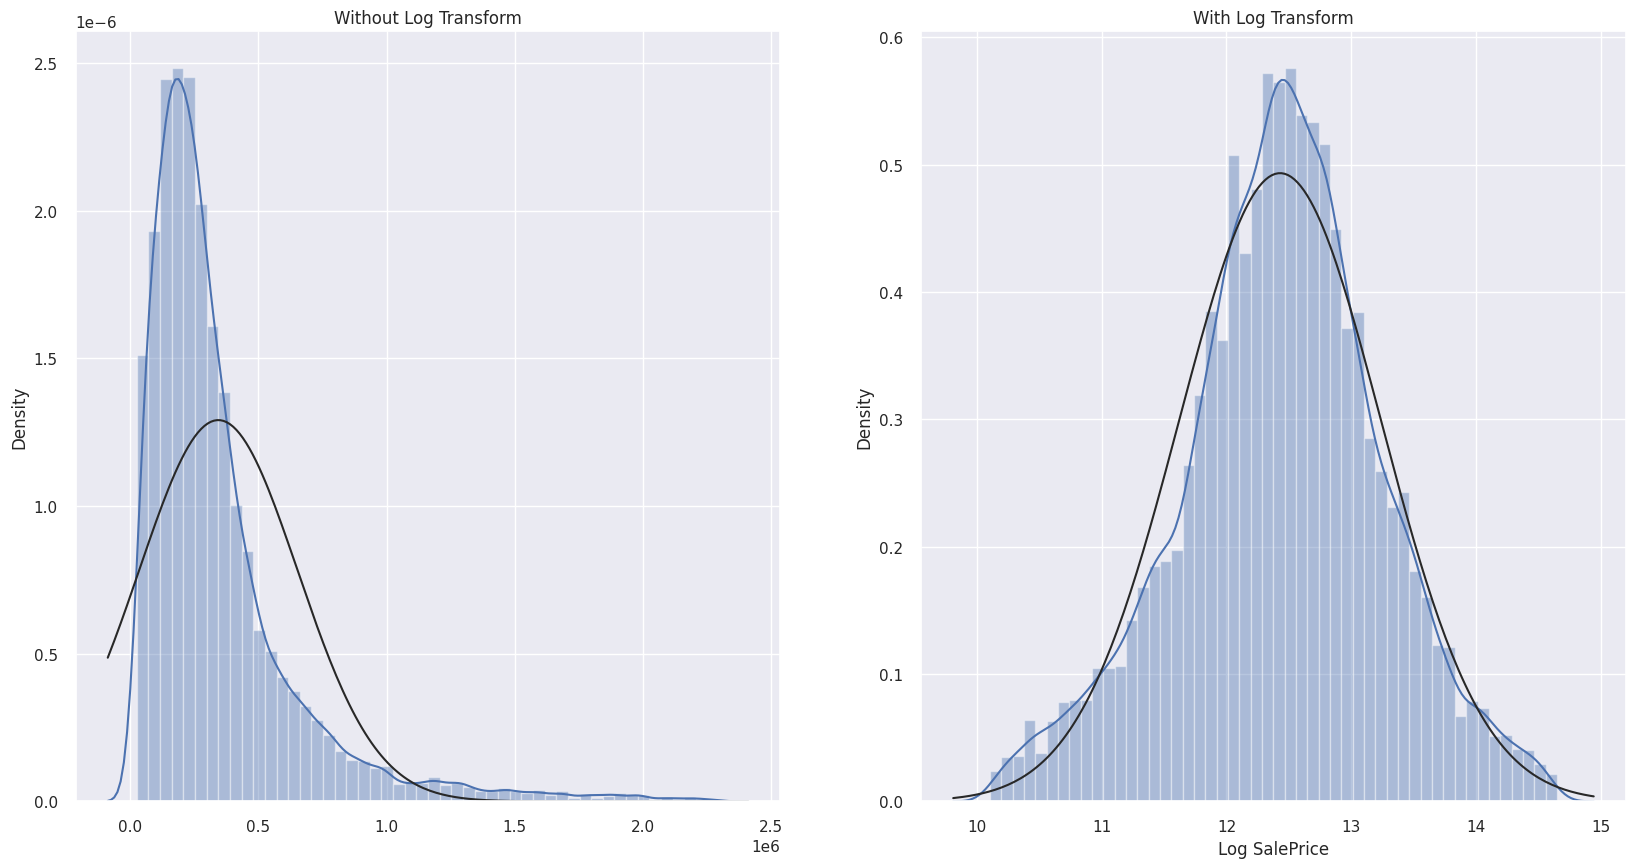

In [143]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sb.distplot(Y_train_0, kde=True, fit=sp.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sb.distplot(np.log(Y_train_0), kde=True, fit=sp.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()


In [12]:
Y_train_1=np.log(Y_train_0)

## 7. Model Selection


In [13]:
X_train_1=data_5.loc[:X_train_0.index.max(),:]
X_train_1.head()

,approximate_latitude,approximate_longitude,postal_code,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,...,property_type_gîte,property_type_hôtel,property_type_hôtel particulier,property_type_loft,property_type_maison,property_type_manoir,property_type_moulin,property_type_parking,property_type_propriété,property_type_péniche,property_type_terrain,property_type_terrain à bâtir,property_type_viager,property_type_villa
0,-1.230185,1.728803,-1.643535,-0.184695,-0.116149,-0.078300,-0.067279,-0.099833,-0.415909,-0.381082,0.280099,-0.646351,-0.468614,-0.856026,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
1,-0.359793,0.873048,0.540915,-0.179866,0.448365,-0.077434,0.011669,0.051358,0.247776,0.530459,-0.573299,-0.646351,-0.468614,0.006854,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
2,0.603565,-1.482872,-0.641736,-0.185053,-0.321427,-0.074476,-0.090842,-0.039087,-0.747751,-0.836853,0.280099,-0.646351,-0.468614,-0.856026,...,-0.009255,-0.004627,-0.012243,-0.039293,1.179588,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
3,0.316174,-1.736472,-0.321341,-0.170565,-0.321427,-0.062459,0.004382,0.024360,-0.084066,0.074688,0.280099,-0.646351,2.133951,0.006854,...,-0.009255,-0.004627,-0.012243,-0.039293,1.179588,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156
4,-0.349936,0.853258,0.534215,-0.180224,0.448365,-0.084583,-0.150114,-0.082959,-0.084066,0.074688,0.280099,-0.646351,2.133951,-0.640306,...,-0.009255,-0.004627,-0.012243,-0.039293,-0.847753,-0.021209,-0.023142,-0.051385,-0.104023,-0.015348,-0.207331,-0.088993,-0.069574,-0.147156


In [14]:
X_train_1.index.max()


37367

In [15]:
X_test_1=data_5.loc[X_train_0.index.max()+1:,:]
X_test_1.head()
X_test_1.to_pickle("data/X_test_1.pkl")

In [16]:
data_6=pd.concat([X_train_1, Y_train_1], axis=1)
data_6.to_pickle("data/data.pkl") 

In [17]:
#from metrics.custom_metric_ilb import custom_metric_function
from pycaret.regression import compare_models, setup
import pycaret


In [ ]:
#setup(feature_interaction=True,polynomial_features=True,use_gpu = True, silent = True, data = data_6, target="price")

In [ ]:
#compare_models()

In [ ]:
#baseline model
baseline_model=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto')
baseline_model.fit(X_train_1, Y_train_1)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
# Baseline model evaluation
# kf = KFold(n_splits=10)
# baseline_result = cross_val_score(baseline_model, X_train_1, Y_train_1, scoring="neg_mean_absolute_error", cv=kf)

# mean_baseline_result = -np.mean(baseline_result)
# print(mean_baseline_result)

## 9. Ensembling

In [18]:
models = {
    "xgboost":XGBRegressor(),
    # "lgbm":LGBMRegressor(),
    "rfr":RandomForestRegressor(),
    "etr":ExtraTreesRegressor(),
    # "gbr":GradientBoostingRegressor()
}

for model_name, model in models.items():
    model.fit(X_train_1, Y_train_1)
    print(f"Finished Training {model_name}.")


Finished Training xgboost.
Finished Training rfr.
Finished Training etr.


In [ ]:
results={}

for model_name, model in models.items() :
    result = cross_val_score(model, X_train_1, Y_train_1, scoring="neg_mean_absolute_error", cv=kf)
    results[model_name]=result

In [ ]:
for model_name, result in results.items():
    print(f"{model_name}. Mean : {-np.mean(result)}  & Var : {-np.std(result)} ")

""" Submission 3

xgboost. Mean : 0.28985788113138333  & Var : -0.002490919470054681 
rfr.     Mean : 0.286342086929681  & Var : -0.004284923275662152 
etr.     Mean : 0.28656718456340535  & Var : -0.0032716820170574806 
"""


xgboost. Mean : 0.28985788113138333  & Var : -0.002490919470054681 
rfr. Mean : 0.286342086929681  & Var : -0.004284923275662152 
etr. Mean : 0.28656718456340535  & Var : -0.0032716820170574806 


## 8. Hyperparameter Optimization

In [19]:
final_predictions_raw = (
    1/3*np.exp(models["xgboost"].predict(X_test_1)) +
    # 0.2*np.exp(models["lgbm"].predict(X_test_1)) +
    1/3*np.exp(models["rfr"].predict(X_test_1)) +
    1/3*np.exp(models["etr"].predict(X_test_1)) 
    # 0.2*np.exp(models["gbr"].predict(X_test_1)) 
    )


## 10. Feauture selection


## 11. Submission

Baseline model predictions : 

In [94]:
# predictions = pd.Series(np.exp(baseline_model.predict(X_test_1)), name="price")
# submission=pd.concat([X_test_ids, predictions], axis=1)
# submission.to_csv("data/submission.csv", index=False, header=True)

Ensemble model predictions :

In [20]:
final_predictions=pd.Series(final_predictions_raw,name="price")
final_submission = pd.concat([X_test_ids, final_predictions], axis=1)
final_submission.to_csv("data/final_submission_4.csv", index=False, header=True)
